In [10]:
import math
import numpy as np
import copy
import matplotlib.pyplot as plt

In [11]:
profiles = {
    'line':  [ [[1,1,1,1]], [[1],[1],[1],[1]] ],
    'block': [ [[1,1],[1,1]] ],
    't-block': [ [[1,1,1],[0,1,0]],[[0,1,0],[1,1,1]], [[1,0],[1,1],[1,0]] , [[0,1],[1,1],[0,1]]],
    'left_l': [   [[1,1,1],[1,0,0]],  [[0,0,1],[1,1,1]], [[1,0],[1,0],[1,1]], [[1,1],[0,1],[0,1]] ],
    'right_l':  [ [[1,1,1],[0,0,1]], [[1,0,0],[1,1,1]] , [[1,1],[1,0],[1,0]] , [[0,1],[0,1],[1,1]]   ],
    'zigzag_r': [ [[1,1,0],[0,1,1]], [[0,1],[1,1],[1,0]] ], 
    'zigzag_l': [ [[0,1,1],[1,1,0]], [[1,0],[1,1],[0,1]] ]
}

In [12]:
class piece():
    def __init__(self,piece_type):
        self.profile = profiles[piece_type]
        
    def get_profile(self):
        return self.profile
    
    def get_rot_profile(self):
        return self.profile
        

In [13]:
def generate_pieces(num_pieces,classes):
    list_of_pieces = []
    for i in range(num_pieces):
        piece_id = np.random.randint(0,len(classes))
        curr_piece = piece(classes[piece_id])
        list_of_pieces.append(curr_piece)
    
    return list_of_pieces

In [14]:
def initialize_dp(num_pieces,height,width):
    dp_size = []
    dp_size.append(num_pieces+1)
    for i in range(width):
        dp_size.append(height+1)
    dp = np.zeros((tuple(dp_size)))
    
    skyline = np.ones((width))*height
    while not end_topo_ordering(skyline):
        #print(skyline)
        curr_dp = np.concatenate((np.asarray([num_pieces]),skyline),axis=0)
        if ( np.max(skyline) < height):
            dp[tuple(curr_dp.astype(int))] = 1
        skyline = get_next_topo(skyline,height)
    
    return dp

In [15]:
def end_topo_ordering(heights):
    
    if (heights[0]) == -1:
        return True
    
    return False

In [16]:
def get_next_topo(heights,max_height):
    
    width = heights.shape[0]
    if max(heights) == 0:
        heights[0] = -1
        return heights
    else:
        pos = 0
        while pos<width and heights[pos]==0:
            pos = pos + 1
        for i in range(pos):
            heights[i] = max_height
        heights[pos] = heights[pos] - 1
        return heights
    
    

In [17]:
class game():
    def __init__(self,height,width,num_pieces,classes):
        self.height = height
        self.width = width
        self.num_pieces = num_pieces
        self.pieces = generate_pieces(num_pieces,classes)
        self.pieces_rev = copy.deepcopy(self.pieces)
        self.pieces_rev.reverse()
        self.dp = initialize_dp(num_pieces,height,width)
        
    
    def check_validity(self,h):
        if np.max(h) >= self.height:
            return False
        return True
        
    def solve_game(self):
        for i in range(self.num_pieces):
            p_ind = (self.num_pieces - 1) - i
            print(p_ind)
            skyline = np.ones((self.width))*self.height
            #print(skyline)
            while not end_topo_ordering(skyline):
                #print(skyline)
                max_val = 0
                #### skylines of updates
                updates = self.get_poss_updates(skyline,self.pieces[p_ind])
                #print(skyline)
                for j in range(len(updates)):
                    curr_update = updates[j]
                    poss_game = np.concatenate((np.asarray([p_ind+1]),curr_update),axis=0)
                    if (self.check_validity(curr_update)):
                        if ( self.dp[tuple(poss_game.astype(int))] > max_val):
                            max_val = self.dp[tuple(poss_game.astype(int))]
                curr_game = np.concatenate((np.asarray([p_ind]),skyline),axis=0)
                self.dp[tuple(curr_game.astype(int))] = max_val
                skyline = get_next_topo(skyline,self.height)
        
    def get_poss_updates(self,skyline,new_piece):
        poss_updates = []
        piece_profiles = new_piece.get_rot_profile()
        ##### check rotations
        for i in range(len(piece_profiles)):
            
            curr_profile = piece_profiles[i]
            prof_width = len(curr_profile[0])
            prof_height = len(curr_profile)
            ##### check positions
            for j in range(self.width+1-prof_width):
                curr_skyline = copy.deepcopy(skyline)
                #### find contact point
                max_h_eff = -1
                contact_point = -1
                for k in range(prof_width):
                    
                    ##### 
                    curr_pos = j + k
                    gap = -1
                    n = 0
                    while gap == -1:
                        if (curr_profile[n][k] == 1):
                            gap = n
                        else:
                            n = n + 1
                    
                    height_eff = curr_skyline[curr_pos]-gap
                    if (height_eff > max_h_eff):
                        max_h_eff = height_eff
                        contact_point = curr_pos
                    
                contact_level = curr_skyline[contact_point]+1
                
                        
                for k in range(prof_width):
                    curr_pos = j + k
                    
                    for n in range(prof_height):
                        if (curr_profile[n][k] == 1):
                            new_height = contact_level + n
                        
                    curr_skyline[curr_pos] = new_height
                    
                poss_updates.append(curr_skyline)
                
                    
                    
        return poss_updates
    
    def get_strategy(self):
        strategy = np.zeros((self.width,self.height))
        skyline = np.zeros((self.width))
        for m in range(self.num_pieces):
            p_ind = m
            piece_profiles = self.pieces[m].get_rot_profile()
            ##### check rotations
            strategy,skyline = self.update_strategy(strategy,skyline,piece_profiles,p_ind)
            #print(strategy)
            #print(skyline)
        return strategy
    
    def update_strategy(self,strategy,skyline,piece_profiles,p_ind):
        for i in range(len(piece_profiles)):
            curr_profile = piece_profiles[i]
            prof_width = len(curr_profile[0])
            prof_height = len(curr_profile)
            ##### check positions
            for j in range(self.width+1-prof_width):
                curr_skyline = copy.deepcopy(skyline)
                #### find contact point
                max_h_eff = -1
                contact_point = -1
                for k in range(prof_width):
                    ##### 
                    curr_pos = j + k
                    gap = -1
                    n = 0
                    while gap == -1:
                        if (curr_profile[n][k] == 1):
                            gap = n
                        else:
                            n = n + 1
                    height_eff = curr_skyline[curr_pos]-gap
                    if (height_eff > max_h_eff):
                        max_h_eff = height_eff
                        contact_point = curr_pos
                contact_level = curr_skyline[contact_point]+1
                for k in range(prof_width):
                    curr_pos = j + k
                    for n in range(prof_height):
                        if (curr_profile[n][k] == 1):
                            new_height = contact_level + n
                    curr_skyline[curr_pos] = new_height
                curr_game = np.concatenate(([p_ind+1],curr_skyline),axis = 0)
                if (self.check_validity(curr_skyline)):
                    if (self.dp[tuple(curr_game.astype(int))]):
                        random_val = np.random.rand()
                        for x in range(prof_width):
                            for y in range(prof_height):
                                if curr_profile[y][x] == 1:
                                    strategy[int(j+x),int(contact_level-1+y)] = random_val
                                    
                        soln = np.rot90(strategy,1)
                        rows,cols = soln.shape
                        soln = np.ma.masked_where(soln == 0, soln)
                        plt.imshow(soln, interpolation='nearest', extent=[0, cols, 0, rows],cmap='Spectral',vmin=0,vmax=1)
                        out = 'game_board' + str(p_ind) + '.png'
                        plt.savefig(out)
                        plt.show()
                        return strategy,curr_skyline
    
    def is_possible(self):
        curr_game = np.zeros((self.width+1))
        return self.dp[tuple(curr_game.astype(int))]
        

In [ ]:
##### height width num_pieces classes
sim = game(12,5,13,['line','block','t-block','left_l','right_l','zigzag_r','zigzag_l'])

In [ ]:
sim.solve_game()

12
11


In [132]:
print(sim.is_possible())

1.0


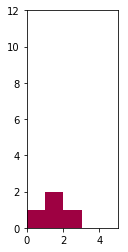

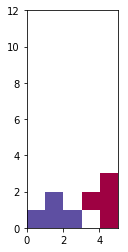

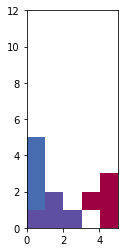

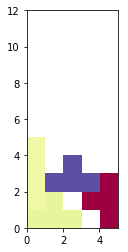

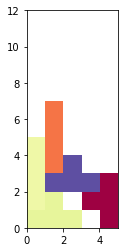

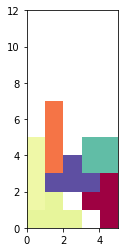

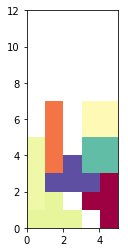

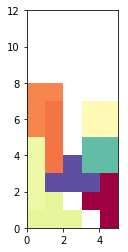

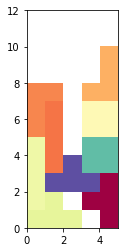

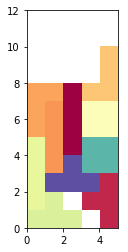

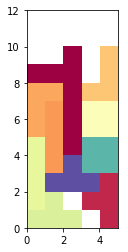

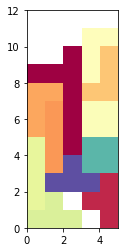

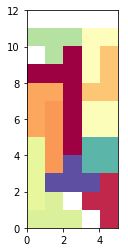

In [133]:
if (sim.is_possible()):
    soln = sim.get_strategy()
else:
    print('Impossible')

In [134]:
soln = np.rot90(soln,1)
print(soln)

[[0.         0.         0.         0.         0.        ]
 [0.64739064 0.64739064 0.64739064 0.50219792 0.50219792]
 [0.         0.64739064 0.12395845 0.50219792 0.39401377]
 [0.12395845 0.12395845 0.12395845 0.50219792 0.39401377]
 [0.34640691 0.34640691 0.12487836 0.39401377 0.39401377]
 [0.34640691 0.32827495 0.12487836 0.51992576 0.51992576]
 [0.34640691 0.32827495 0.12487836 0.51992576 0.51992576]
 [0.57671213 0.32827495 0.12487836 0.75311404 0.75311404]
 [0.57671213 0.32827495 0.8924419  0.75311404 0.75311404]
 [0.57671213 0.8924419  0.8924419  0.8924419  0.17452503]
 [0.57671213 0.59869001 0.         0.17452503 0.17452503]
 [0.59869001 0.59869001 0.59869001 0.         0.17452503]]


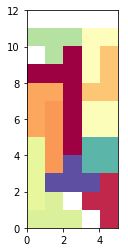

In [135]:
rows,cols = soln.shape
soln = np.ma.masked_where(soln == 0, soln)
plt.imshow(soln, interpolation='nearest', 
                 extent=[0, cols, 0, rows],
                 cmap='Spectral')
plt.show()

In [136]:
import glob
import moviepy.editor as mpy

gif_name = 'tetris'
fps = 3
file_list = []
for i in range(sim.num_pieces):
    curr_file = 'game_board' + str(i) + '.png'
    file_list.append(curr_file)
clip = mpy.ImageSequenceClip(file_list, fps=fps)
clip.write_gif('{}.gif'.format(gif_name), fps=fps)

t:  38%|███▊      | 5/13 [00:00<00:00, 41.54it/s, now=None]

MoviePy - Building file tetris.gif with imageio.
